## Text Summarization with seq2seq model

In [1]:
import numpy as np
import pandas as pd

In [2]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print(summary)
print(raw)

                  author                   date  \
0           Chhavi Tyagi   03 Aug 2017,Thursday   
1            Daisy Mowke   03 Aug 2017,Thursday   
2         Arshiya Chopra   03 Aug 2017,Thursday   
3          Sumedha Sehra   03 Aug 2017,Thursday   
4     Aarushi Maheshwari   03 Aug 2017,Thursday   
...                  ...                    ...   
4509      Mansha Mahajan     24 Feb 2017,Friday   
4510      Dishant Sharma   03 Aug 2017,Thursday   
4511       Tanya Dhingra   03 Aug 2017,Thursday   
4512      Pragya Swastik  07 Dec 2016,Wednesday   
4513        Chhavi Tyagi   03 Aug 2017,Thursday   

                                              headlines  \
0     Daman & Diu revokes mandatory Rakshabandhan in...   
1     Malaika slams user who trolled her for 'divorc...   
2     'Virgin' now corrected to 'Unmarried' in IGIMS...   
3     Aaj aapne pakad liya: LeT man Dujana before be...   
4     Hotel staff to get training to spot signs of s...   
...                              

In [4]:
#extract headlines and text
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [5]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [6]:
print(pre)

                                                     text  \
0       Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1       Kunal Shah's credit card bill payment platform...   
2       New Zealand defeated India by 8 wickets in the...   
3       With Aegon Life iTerm Insurance plan, customer...   
4       Speaking about the sexual harassment allegatio...   
...                                                   ...   
102910  Mansha Mahajan 24 Feb 2017,Friday http://india...   
102911  Dishant Sharma 03 Aug 2017,Thursday http://ind...   
102912  Tanya Dhingra 03 Aug 2017,Thursday http://www....   
102913  Pragya Swastik 07 Dec 2016,Wednesday http://in...   
102914  Chhavi Tyagi 03 Aug 2017,Thursday http://india...   

                                                  summary  
0       upGrad learner switches to career in ML & Al w...  
1       Delhi techie wins free food from Swiggy for on...  
2       New Zealand end Rohit Sharma-led India's 12-ma...  
3       Aegon life iTerm in

In [7]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [8]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [9]:
#!pip uninstall murmurhash
#!pip uninstall spacy


In [10]:
#! pip install -U spacy

In [11]:
#!pip install -U pip setuptools wheel

In [12]:
from time import time
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Time to clean up everything: 7.45 mins


In [13]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.51 mins


In [14]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)
text_count = []
summary_count = []
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

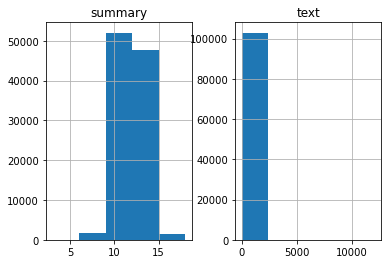

In [15]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [16]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9978234465335472


In [17]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [18]:
max_text_len=100
max_summary_len=15

In [19]:
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [22]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Using TensorFlow backend.


In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [30]:
!pip install -U gensim

Processing /home/jovyan/.cache/pip/wheels/44/1e/2b/b0056a533d057c3ed56c84fbdd79cca690496f4cd7c03c157c/gensim-4.2.0-cp36-cp36m-linux_x86_64.whl
  Using cached smart_open-6.0.0-py3-none-any.whl (58 kB)


In [32]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.keras.layers import AdditiveAttention
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

#encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#attention layer
attention_result = AdditiveAttention(use_scale=True)([decoder_outputs, encoder_outputs])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(attention_result)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.save("main_model_attention.h5")
model.summary()

Size of vocabulary from the w2v model = 33412
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6682400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    2316200     input_2[0][0]                    
________________________________________________

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [34]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 88517 samples, validate on 9836 samples
Epoch 1/50
88517/88517 [==============================] - 145s 2ms/sample - loss: 5.3754 - val_loss: 4.9601
Epoch 2/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 4.8742 - val_loss: 4.6487
Epoch 3/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 4.6034 - val_loss: 4.4699
Epoch 4/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 4.4275 - val_loss: 4.2772
Epoch 5/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 4.2800 - val_loss: 4.1557
Epoch 6/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 4.1581 - val_loss: 4.0518
Epoch 7/50
88517/88517 [==============================] - 140s 2ms/sample - loss: 4.0479 - val_loss: 3.9550
Epoch 8/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 3.9478 - val_loss: 3.8759
Epoch 9/50
88517/88517 [==============================] - 139s 2ms/sample - loss: 3.857

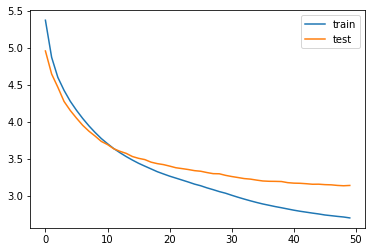

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [37]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
encoder_model.save("encoder_model_attention.h5")
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attention_result2 = AdditiveAttention(use_scale=True)([decoder_outputs2, decoder_hidden_state_input])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(attention_result2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
decoder_model.save("decoder_model_attention.h5")

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print("sampled_token_index: ",sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        print("sampled_token:",sampled_token)

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis 
Original summary: start pope avoids mention of rohingyas in key myanmar speech end 
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  2
sampled_token: start
sampled_t

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start start start start start start start start start start start start


Review: external affairs minister sushma swaraj on saturday called upon the united nations to pass the comprehensive convention on international terrorism to end pakistan sponsored terrorism proposed by india in 1996 aims to arrive at universal definition of terro

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  to to to to to to to to to to to to to to


Review: a case has been registered against raja chauhan for firing gunshots in violence during bharat bandh called by dalit groups in madhya pradesh gwalior on monday video showing chauhan alleged to be bjp worker firing during the protest had surfaced online of the 12 people killed during the nationwide protests at least three were from gwalior 
Original summary: start case filed man who fired in dalit protests end 
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampl

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  to to to to to to to to to to to to to to


Review: pakistan chief selector inzamam ul haq nephew imam ul haq collided with wicketkeeper brien and kane while completing single off ireland first ever test delivery on saturday debutant imam fell flat on his back after his head into brien hip while trying to make his crease uncle would ve just both fielders user tweeted reacting to the incide

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  start start start to to to to to to to to to to to


Review: bangladesh pm sheikh hasina has accused myanmar of finding new excuses to delay the return of over lakh rohingya muslims who fled myanmar to enter bangladesh over the past year adding that under no would the refugees remain permanently in bangladesh hasina said already have 16 crore people in my country can take any othe

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start start start start start start start start start start start start


Review: sridevi starrer song hawa hawai from the 1987 film mr india has been recreated for vidya balan film tumhari sulu the vocals of kavita krishnamurthy who sang the original song have been retained and the new version has been recreated and programmed by tanishk bagchi directed by suresh triveni tumhari sulu is scheduled to release on november 17 
Original summary: start hawa hawai recreated for tumhari sulu end 
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sa

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  to to to to to to to to to to to to to to


Review: aimim president asaduddin owaisi has said that no beef ban in three northeast states which will go to polls next year reflects dual standards and hypocrisy in up bjp is doing appeasement of hindutva forces he added his remark came after the bjp clarified that it will not impose beef ban in northeastern states if voted to power 
Original s

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start start start start start start start start start start start start


Review: the mumbai police on wednesday cancelled the conditional licences granted to the three of the city dance bars for failing to comply with fire safety norms the establishments didn respond to repeated show cause notices and failed to produce the required doc

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start start start start start start start start start start start start


Review: a farmer in karnataka has filed complaint against bjp workers for allegedly destroying his farmland for constructing helipad for party president amit shah he claimed the bjp workers had entered the land forcefully and abused him when he questioned them bjp spokesperson prakash said that any high handedness by local leaders will be looked into 
Original summary: start farmer claims bjp workers destroyed land for shah end 
sampled_token_index:  488
sampled_token: workers
sampled_token_index:  488
sampled_token: workers
sampled_token_index:  488
sampled_token: workers
sampled_token_index:  488
sampled_token: wor

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  start start start to to to to to to to to to to to


Review: actress margot best known for playing the role of lois lane in the superman film franchise of the 1970s and 1980s passed away on sunday at the age of 69 an autopsy will be performed to determine the cause of her death margot who suffered from car accident in 1990 had experienced long term mental health issues 
Original summary: start actress who portrayed lane in superman film passes away end 
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  281
sampled_token: actress
sampled_token_index:  281
sampled_token: actress
samp

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  to to to to to to to to to to to to to to


Review: us senator elizabeth warren has proposed new wealth tax which would cost the world richest person jeff bezos 4 1 billion in the first year warren proposed wealth tax of 2 on americans with assets above 50 million and 3 on all fortunes above 1 billion almost all of bezos 137 1 billion wealth is tied up in amazon stock 
Original summary: st

sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
Predicted summary:  to to to to to to to to to to to to to to


Review: indo canadian youtube star lilly singh also known as superwoman said if you watch something and it makes you laugh great if it doesn that comedy isn wrong it just not suitable for you calling comedy very lilly added the best thing you can do is promote what you love and not bash what you hate 
Original summary: start if it doesn make you laugh that comedy isn wrong end 
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_t

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start start start start start start start start start start start start


Review: former india cricketer sachin tendulkar paid surprise visit to child care centre in mumbai dressed as santa claus on the occasion of christmas on tuesday sachin spent time with the underprivileged children gave them gifts and also played cricket with them 

sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  5
sampled_token: to
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
sampled_token_index:  2
sampled_token: start
Predicted summary:  start start start to to to to to to to to start start start


Review: a man in uttar pradesh lucknow built drone in hours to rescue puppy after he saw it drowning in drain the man who makes robots for living assembled an ai controlled robotic arm and attached it to the drone he said that initially he asked people for help but they advised him to let it die 
Original summa

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


ValueError: Attempted to save a function b'__inference_lstm_layer_call_fn_192810' which references a symbolic Tensor Tensor("dropout/mul_1:0", shape=(None, 200), dtype=float32) that is not a simple constant. This is not supported.